# Homework Assignment 2

In [28]:
from datetime import date, datetime, timedelta
from pathlib import Path
import random
import os
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import random

### Check necessary modules

In [29]:
try:
    import zarr
except ImportError:
    !pip install zarr
    import zarr

In [30]:
try:
    import hpgeom as hpg
except ImportError:
    !pip install hpgeom
    import hpgeom as hpg

In [31]:
try:
    import cdsapi
except ImportError:
    !pip install cdsapi
    import cdsapi

## Task 1 - Core control flow & mock-processing

### Date Logic

In [32]:
# Generator function to find and store all dates inside of the given range, inclusive the start and end date 
def daterange(start, end):
    
    current = start
    while current <= end:
        yield current
        current += timedelta(days=1)

### Status Check

In [33]:
# If necessary, a new directory will be created
BASE_DIR = Path("processed_data")
BASE_DIR.mkdir(exist_ok=True)

# Checks whether a date has already been processed
def is_day_processed(day: date) -> bool:
    # A date is considered processed if a folder exists for it
    return (BASE_DIR / day.isoformat()).exists()

### Mock-Processing

In [34]:
# Mock-processing that simulates download, processing and archiving of daily files
def mock_process_day(day, fail_probability=0.2):
    print(f"→ Processing {day}")

    # Simulating a random error during download
    if random.random() < fail_probability:
        raise RuntimeError("Mock download failed")

    # Save the daily mock file
    day_dir = BASE_DIR / day.isoformat()
    day_dir.mkdir(parents=True, exist_ok=True)

    with open(day_dir / "done.txt", "w") as f:
        f.write(f"Processed on {datetime.now()}\n")

    print(f"✓ {day} successfully processed")

### Find oldest missing day

In [35]:
# Find the oldest missing day of a given date range 
def find_oldest_missing_day(start, end) -> date | None:
    for d in daterange(start, end):
        # Use the established logic
        if not is_day_processed(d):
            return d
    return None

### Find oldest processed day

In [36]:
# Find the oldest fully processed day in the directory
def find_oldest_processed_day(processed_dir, date_format):
    
    oldest_date = None
    
    for entry in os.listdir(processed_dir):
        folder_path = os.path.join(processed_dir, entry)
        if not os.path.isdir(folder_path):
            continue  # Skip files, just looking for folders
        
        try:
            folder_date = datetime.strptime(entry, date_format).date() # Extract date from folder name
        except ValueError:
            # Ignore files that do not match the given date format
            continue

        # Check whether “Done.txt” exists in the folder
        done_file = os.path.join(folder_path, "Done.txt")
        if not os.path.isfile(done_file):
            continue  # Date has not been fully processed
            
        if oldest_date is None or folder_date < oldest_date:
            oldest_date = folder_date

    return oldest_date

### Check dates

In [37]:
def check_dates(
    start_date,
    end_date,
    target_date = None
):
    if end_date and start_date is not None:
        if end_date < start_date:
            raise ValueError("✗ End_date is before start_date")

### Central Workflow

In [38]:
# Central control flow that handles the daily data
def run_daily_workflow(
    start_date = None,
    end_date = None,
    target_date = None, 
    # ensure proper functionaility when script is executed w/o arguments
):

    # If the function is called without start_date, find a suitable start date
    if start_date is None:
        start_date = find_oldest_processed_day(BASE_DIR, "%Y-%m-%d")
    
    # If the function is called without end_date, find a suitable end date
    if end_date is None:
        end_date = date.today()
    
    # Check that the given date range is correct
    check_dates(start_date, end_date)
    
    # Check whether a target date or all days within the range should be processed
    if target_date is not None:
            
        print(f"Start workflow for individual target date: {target_date}")
        try:
            mock_process_day(target_date)
        except Exception as e:
            print(f"✗ Error on {target_date}: {e}")
        return

    print("Start workflow for all missing days")

    while True:
        missing_day = find_oldest_missing_day(start_date, end_date)
        if missing_day is None:
            print("✓ All days are processed")
            break

        try:
            mock_process_day(missing_day)
        except Exception as e:
            print(f"✗ Error on {missing_day}: {e}")
            print("→ Error logged, next day will be processed")

## Task 2 - Flexible ERA5 donwload routine

### ERA5 configuration dictionary

In [39]:
# This dictionary is used to easily adapt the donwload routine to other parameter values as stated in the assignment.
# No hardcoded settings within the download routine of the core workflow  

ERA5_CONFIG = {
    "dataset": "reanalysis-era5-pressure-levels",
    "format": "netcdf",
    "variable": ["specific_humidity"],
    "pressure_levels": [975, 900, 800, 500, 300],
    "times": ["00:00", "06:00", "12:00", "18:00"],
    "filename": "era5_humidity.nc",
}

### Download ERA5 data

In [40]:
# Downloads ERA5 humidity data for a single given day
def download_era5_humidity(day):

    # Save the daily data
    day_dir = BASE_DIR / day.isoformat()
    day_dir.mkdir(exist_ok=True)

    target_file = day_dir / "era5_humidity.nc"

    # CDS API request
    c = cdsapi.Client()
    request = {
        "product_type": "reanalysis",
        "variable": ERA5_CONFIG["variable"],
        "pressure_level": [str(p) for p in ERA5_CONFIG["pressure_levels"]],
        "year": day.strftime("%Y"),
        "month": day.strftime("%m"),
        "day": day.strftime("%d"),
        "time": ERA5_CONFIG["times"],
        "format": ERA5_CONFIG["format"],
    }

    print(f"↓ Download ERA5 humidity data for {day}")
    c.retrieve(
        "reanalysis-era5-pressure-levels",
        request,
        str(target_file),
    )

    # Flag as processed
    (day_dir / "Done.txt").write_text("OK\n")

### Central workflow with ERA5 download

In [41]:
# Central control flow that handles the daily ERA5 data
def run_daily_era5_workflow(
    start_date = None,
    end_date = None,
    target_date = None, 
    # ensure proper functionaility when script is executed w/o arguments
):

    # If the function is called without start_date, find a suitable start date
    if start_date is None:
        start_date = find_oldest_processed_day(BASE_DIR, "%Y-%m-%d")
        
    # If the function is called without end_date, find a suitable end date    
    if end_date is None:
        end_date = date.today()
        
    # Check that the given date range is correct
    check_dates(start_date, end_date)
        
    # Check whether a target date or all days within the range should be processed       
    if target_date is not None:
        
        print(f"Start workflow for individual day: {target_date}")
        try:
            download_era5_humidity(target_date)
        except Exception as e:
            print(f"✗ Error on {target_date}: {e}")
        return

    print("Start workflow for all missing days")

    while True:
        missing_day = find_oldest_missing_day(start_date, end_date)
        if missing_day is None:
            print("✓ All days are processed")
            break

        try:
            download_era5_humidity(missing_day)
        except Exception as e:
            print(f"✗ Error on {missing_day}: {e}")
            print("→ Error logged, next day will be processed")

## Task 3 - Interpolation

### Interpolate daily data batches 

In [42]:
# Interpolates daily ERA5 data into a HEALPix grid of nside 8 and 16 using the hpgeom module
def interpolate_to_healpix(day, nside_list=[8, 16]):

    print("Start interpolation...")
    
    day_dir = BASE_DIR / day.isoformat()
    input_file = day_dir / "era5_humidity.nc"

    if not input_file.exists():
        raise FileNotFoundError(f"Missing ERA5 file for {day}")

    ds = xr.open_dataset(input_file)

    time_dim = "valid_time"
    level_dim = "pressure_level"
    q = ds["q"]
    lats = ds["latitude"].values
    lons = ds["longitude"].values

    print("...step 1...")
    
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    src_points = np.column_stack([lat_grid.ravel(), lon_grid.ravel()])

    for nside in nside_list:
        
        print(f"...nside {nside}...")
        
        npix = hpg.nside_to_npixel(nside)
        pixels = np.arange(npix)

        theta, phi = hpg.pixel_to_angle(nside, pixels)
        hp_lats = 90.0 - np.degrees(theta)
        hp_lons = np.degrees(phi)
        tgt_points = np.column_stack([hp_lats, hp_lons])

        hp_q = np.empty(
            (q.sizes[time_dim], q.sizes[level_dim], npix)
        )

        for t in range(q.sizes[time_dim]):
            print(f"...t {t}...")
            for lev in range(q.sizes[level_dim]):
                print(f"...lev {lev}...")
                values = q.isel({time_dim: t, level_dim: lev}).values.ravel()

                interp = griddata(
                    src_points, values, tgt_points, method="linear"
                )

                nan_mask = np.isnan(interp)
                if np.any(nan_mask):
                    interp[nan_mask] = griddata(
                        src_points,
                        values,
                        tgt_points[nan_mask],
                        method="nearest"
                    )

                hp_q[t, lev, :] = interp

        out_ds = xr.Dataset(
            data_vars={
                "q": ((time_dim, level_dim, "pixels"), hp_q)
            },
            coords={
                time_dim: ds[time_dim],
                level_dim: ds[level_dim],
                "pixels": pixels,
            },
            attrs={"healpix_nside": nside},
        )

        out_file = day_dir / f"healpix_n{nside}.nc"
        out_ds.to_netcdf(out_file)

        print(f"✓ {day}: interpolated to HEALPix NSIDE={nside}")

### Central Workflow with ERA5 download and interpolation

In [43]:
def run_daily_era5_interpolation_workflow(
    start_date = None,
    end_date = None,
    target_date = None, 
    # ensure proper functionaility when script is executed w/o arguments
    nside_list=[8,16],
):

    # If the function is called without start_date, find a suitable start date
    if start_date is None:
        start_date = find_oldest_processed_day(BASE_DIR, "%Y-%m-%d")
    
    # If the function is called without end_date, find a suitable end date
    if end_date is None:
        end_date = date.today()
    
    # Check that the given date range is correct
    check_dates(start_date, end_date)
        
    # Check whether a target date or all days within the range should be processed
    if target_date is not None:
        
        print(f"Start workflow for individual day: {target_date}")
        try:
            download_era5_humidity(target_date)
            interpolate_to_healpix(target_date, nside_list=nside_list)  # HEALPix Interpolation
        except Exception as e:
            print(f"✗ Error on {target_date}: {e}")
        return

    print("Start workflow for all missing days")

    while True:
        missing_day = find_oldest_missing_day(start_date, end_date)
        if missing_day is None:
            print("✓ All days are processed")
            break

        try:
            download_era5_humidity(missing_day)
            interpolate_to_healpix(missing_day, nside_list=nside_list)
        except Exception as e:
            print(f"✗ Error on {missing_day}: {e}")
            print("→ Error logged, next day will be processed")

## Task 4 - Chunking and save as Zarr

### Chunking and save to Zarr

In [44]:
ZARR_DIR = Path("processed_data_zarr")
ZARR_DIR.mkdir(exist_ok=True)

def save_to_zarr(day, nside, base_dir=BASE_DIR, zarr_root=Path("processed_data_zarr")):
    day_dir = base_dir / day.isoformat()
    input_file = day_dir / f"healpix_n{nside}.nc"
    
    if not input_file.exists():
        raise FileNotFoundError(f"No interpolated file for {day} NSIDE={nside} found")
    
    with xr.open_dataset(input_file) as ds:

        chunk_dict = {dim: 1 if dim == "valid_time" else ds.dims[dim] for dim in ds.dims}
        ds_chunked = ds.chunk(chunk_dict)
        
        zarr_dir = zarr_root / f"healpix_n{nside}.zarr"
        
        if not zarr_dir.exists():
            ds_chunked.to_zarr(zarr_dir, mode="w")
            print(f"✓ Initial Zarr store created: {zarr_dir} (day {day})")
            return 
        
        ds_chunked.to_zarr(zarr_dir, mode="a", append_dim="valid_time")
        print(f"✓ Appended day {day} NSIDE={nside} to Zarr: {zarr_dir}")


### Daily chunking

In [45]:
# Save daily interpolated Healpix data to Zarr using 1 chunk = 1 day along the time dimension.
def save_to_zarr_daily(
    day,
    nside,
    base_dir=BASE_DIR,
    zarr_root=Path("processed_data_zarr"),
    pixel_chunk_size=256,
):

    day_dir = base_dir / day.isoformat()
    input_file = day_dir / f"healpix_n{nside}.nc"

    if not input_file.exists():
        raise FileNotFoundError(
            f"No interpolated file for {day} (NSIDE={nside}) found"
        )

    with xr.open_dataset(input_file) as ds:
        # Chunking strategy 1 chunk = 1 day
        chunk_dict = {
            "valid_time": ds.dims["valid_time"],       # all 4 timesteps
            "pressure_level": ds.dims["pressure_level"],
            "pixels": min(pixel_chunk_size, ds.dims["pixels"]),
        }

        ds_chunked = ds.chunk(chunk_dict)

        zarr_dir = zarr_root / f"healpix_n{nside}.zarr"

        # Check wether a zarr store already exists for nside = x
        if not zarr_dir.exists():
            ds_chunked.to_zarr(zarr_dir, mode="w")
            print(
                f"✓ Created Zarr store for NSIDE={nside} "
                f"(day {day}, chunks={chunk_dict})"
            )
            return

        # Append the new day to the zarr
        ds_chunked.to_zarr(
            zarr_dir,
            mode="a",
            append_dim="valid_time",
        )

        print(
            f"✓ Appended day {day} to Zarr (NSIDE={nside}, "
            f"chunks={chunk_dict})"
        )

### Chunking in correct order

In [46]:
# Insert new data chunk into the zarr instead of only appending to ensure correct chronological order  
def insert_day_sorted(ds_new, zarr_dir):
    
    if not zarr_dir.exists():
        ds_new.to_zarr(zarr_dir, mode="w")
        print(f"✓ Created new Zarr store: {zarr_dir}")
        return

    ds_existing = xr.open_zarr(zarr_dir)

    day_new = ds_new.valid_time.dt.floor("D")[0].item()
    days_existing = ds_existing.valid_time.dt.floor("D").values

    if day_new in days_existing:
        print(f"⚠ Day {day_new} already present → skipping")
        return

    # Combine and sort the chunks
    ds_combined = (
        xr.concat([ds_existing, ds_new], dim="valid_time")
          .sortby("valid_time")
    )

    # Rewrite the new zarr
    ds_combined.to_zarr(zarr_dir, mode="w")
    print(f"✓ Inserted day {day_new} into Zarr: {zarr_dir}")

In [47]:
# Save daily interpolated Healpix data to Zarr using 1 chunk = 1 day along the time dimension.
def save_to_zarr_insert(day, nside, base_dir=BASE_DIR, zarr_root=Path("processed_data_zarr")):
    day_dir = base_dir / day.isoformat()
    input_file = day_dir / f"healpix_n{nside}.nc"

    if not input_file.exists():
        raise FileNotFoundError(f"No interpolated file for {day} NSIDE={nside} found")

    with xr.open_dataset(input_file) as ds:
        # 1 Day = 1 Chunk
        chunk_dict = {
            "valid_time": ds.dims["valid_time"],
            "pressure_level": ds.dims["pressure_level"],
            "pixels": min(512, ds.dims["pixels"]),
        }
        ds_chunked = ds.chunk(chunk_dict)

        zarr_dir = zarr_root / f"healpix_n{nside}.zarr"

        # Execute function to properly sort the chunks into chronological order
        insert_day_sorted(ds_chunked, zarr_dir)

### Central workflow with ERA5 download, interpolation, chunking and saving as Zarr

In [49]:
# 
def run_daily_era5_interpolation_workflow_zarr(
    start_date=None,
    end_date=None,
    target_date=None,
    # ensure proper functionaility when script is executed w/o arguments
    nside_list=[8,16],
):

    # If the function is called without start_date, find a suitable start date
    if start_date is None:
        start_date = find_oldest_processed_day(BASE_DIR, "%Y-%m-%d")
    
    # If the function is called without end_date, find a suitable end date
    if end_date is None:
        end_date = date.today()
        
    # Check that the given date range is correct
    check_dates(start_date, end_date)
    
    # Check whether a target date or all days within the range should be processed
    if target_date is not None:
        print(f"Start workflow for individual day: {target_date}")
        try:
            # Deactivate in case of testing to avoid long run time due to interpolation
            #download_era5_humidity(target_date)
            #interpolate_to_healpix(target_date, nside_list=nside_list)
            
            for nside in nside_list:
                save_to_zarr_insert(target_date, nside)

        except Exception as e:
            print(f"✗ Error on {target_date}: {e}")
        return

    # Workflow when a date range is downloaded
    print("Start workflow for all missing days")

    while True:
        missing_day = find_oldest_missing_day(start_date, end_date)
        if missing_day is None:
            print("✓ All days are processed")
            break

        try:
            download_era5_humidity(missing_day)
            interpolate_to_healpix(missing_day, nside_list=nside_list)

            for nside in nside_list:
                save_to_zarr_insert(missing_day, nside)

        except Exception as e:
            print(f"✗ Error on {missing_day}: {e}")
            print("→ Error logged, next day will be processed")


## Task 5 - Load and plot data

### Configuration dictionary

In [107]:
# Configuration dictionary to adjust the plotting
# You can change the date, two time steps, and the variables you want to plot
PLOT_CONFIG = {
    "date": "2024-12-02",
    "times": {"time_indices": [0, 1]},
    "variable": {
        "name": "q",
        "pressure_level": 900  # hPa
    },
    "healpix": {
        "nsides": [8, 16]
    },
    "paths": { # if you use other directories pass them over here
        "zarr_root": "processed_data_zarr",
        "original_root": "processed_data"
    }
}

### Plot data

In [106]:
# Plot the original ERA5 and regridded data in both resolutions for two different timesteps of one day
def plot_original_and_regridded_final(
    day,
    pressure_level=500,
    time_indices=(0, 1),
    nside_list=(8, 16),
    zarr_root=Path("processed_data_zarr"),
    orig_root=Path("processed_data"),
):

    # Load original ERA5 data 
    orig_file = orig_root / day.isoformat() / "era5_humidity.nc"
    ds_orig = xr.open_dataset(orig_file)

    # Index of pressure_level from original ERA5 data
    pressure_index_orig = int(np.argmin(np.abs(ds_orig["pressure_level"].values - pressure_level)))

    n_rows = len(time_indices)
    n_cols = 1 + len(nside_list)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(6 * n_cols, 5 * n_rows),
        constrained_layout=True
    )
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    # For each resolution compute longitude and latitude 
    lonlat_by_nside = {}
    for nside in nside_list:
        zarr_file = zarr_root / f"healpix_n{nside}.zarr"
        ds_zarr = xr.open_zarr(zarr_file)

        n_pix = int(ds_zarr.dims["pixels"])

        theta = np.arccos(1 - 2 * (np.arange(n_pix) + 0.5) / n_pix)
        phi = (np.pi * (1 + 5 ** 0.5) * (np.arange(n_pix) + 0.5)) % (2*np.pi)

        lon = np.degrees(phi) - 180.0
        lat = 90.0 - np.degrees(theta)

        lonlat_by_nside[nside] = (lon, lat)

    # Create plot for each timestep
    for r, t in enumerate(time_indices):
        # Plot for original ERA5 data
        data_orig = ds_orig["q"].isel(valid_time=t, pressure_level=pressure_index_orig).values
        ax0 = axes[r, 0]
        im0 = ax0.imshow(data_orig, origin="lower", cmap="viridis", aspect="auto")
        ax0.set_title(f"Original ERA5: {day} | P={pressure_level} hPa | t={t}")
        fig.colorbar(im0, ax=ax0, orientation="vertical", label="q")

        # Plot for regridded data for each resolution
        for c, nside in enumerate(nside_list, start=1):
            zarr_file = zarr_root / f"healpix_n{nside}.zarr"
            ds_zarr = xr.open_zarr(zarr_file)

            # Index of pressure_level from zarr file
            pressure_index_zarr = int(np.argmin(np.abs(ds_zarr["pressure_level"].values - pressure_level)))

            data_zarr = ds_zarr["q"].isel(valid_time=t, pressure_level=pressure_index_zarr).values

            lon, lat = lonlat_by_nside[nside]
            ax = axes[r, c]
            sc = ax.scatter(lon, lat, c=data_zarr.ravel(), cmap="viridis", s=20)
            ax.set_title(f"Regridded Healpix NSIDE={nside}: {day} | P={pressure_level} hPa | t={t}")
            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")
            fig.colorbar(sc, ax=ax, orientation="vertical", label="q")

    plt.show()

## Testing

In [30]:
file_path = Path(r"C:\Users\Nils\earth-system-data-processing\data_access\homework02\processed_data\2024-12-02\healpix_n8.nc")

ds = xr.open_dataset(file_path)
print(ds)
print("\nDimensions:", ds.dims)
print("\nCoordinates:", ds.coords)

<xarray.Dataset>
Dimensions:         (valid_time: 4, pressure_level: 5, pixels: 768)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 2024-12-02 ... 2024-12-02T18:...
  * pressure_level  (pressure_level) float64 975.0 900.0 800.0 500.0 300.0
  * pixels          (pixels) int32 0 1 2 3 4 5 6 ... 761 762 763 764 765 766 767
Data variables:
    q               (valid_time, pressure_level, pixels) float64 ...
Attributes:
    healpix_nside:  8

Dimensions: Frozen({'valid_time': 4, 'pressure_level': 5, 'pixels': 768})

Coordinates: Coordinates:
  * valid_time      (valid_time) datetime64[ns] 2024-12-02 ... 2024-12-02T18:...
  * pressure_level  (pressure_level) float64 975.0 900.0 800.0 500.0 300.0
  * pixels          (pixels) int32 0 1 2 3 4 5 6 ... 761 762 763 764 765 766 767


In [50]:
run_daily_era5_interpolation_workflow_zarr(
    target_date=date(2024, 12, 2),
)

Start workflow for individual day: 2024-12-02
✓ Created new Zarr store: processed_data_zarr\healpix_n8.zarr
✓ Created new Zarr store: processed_data_zarr\healpix_n16.zarr


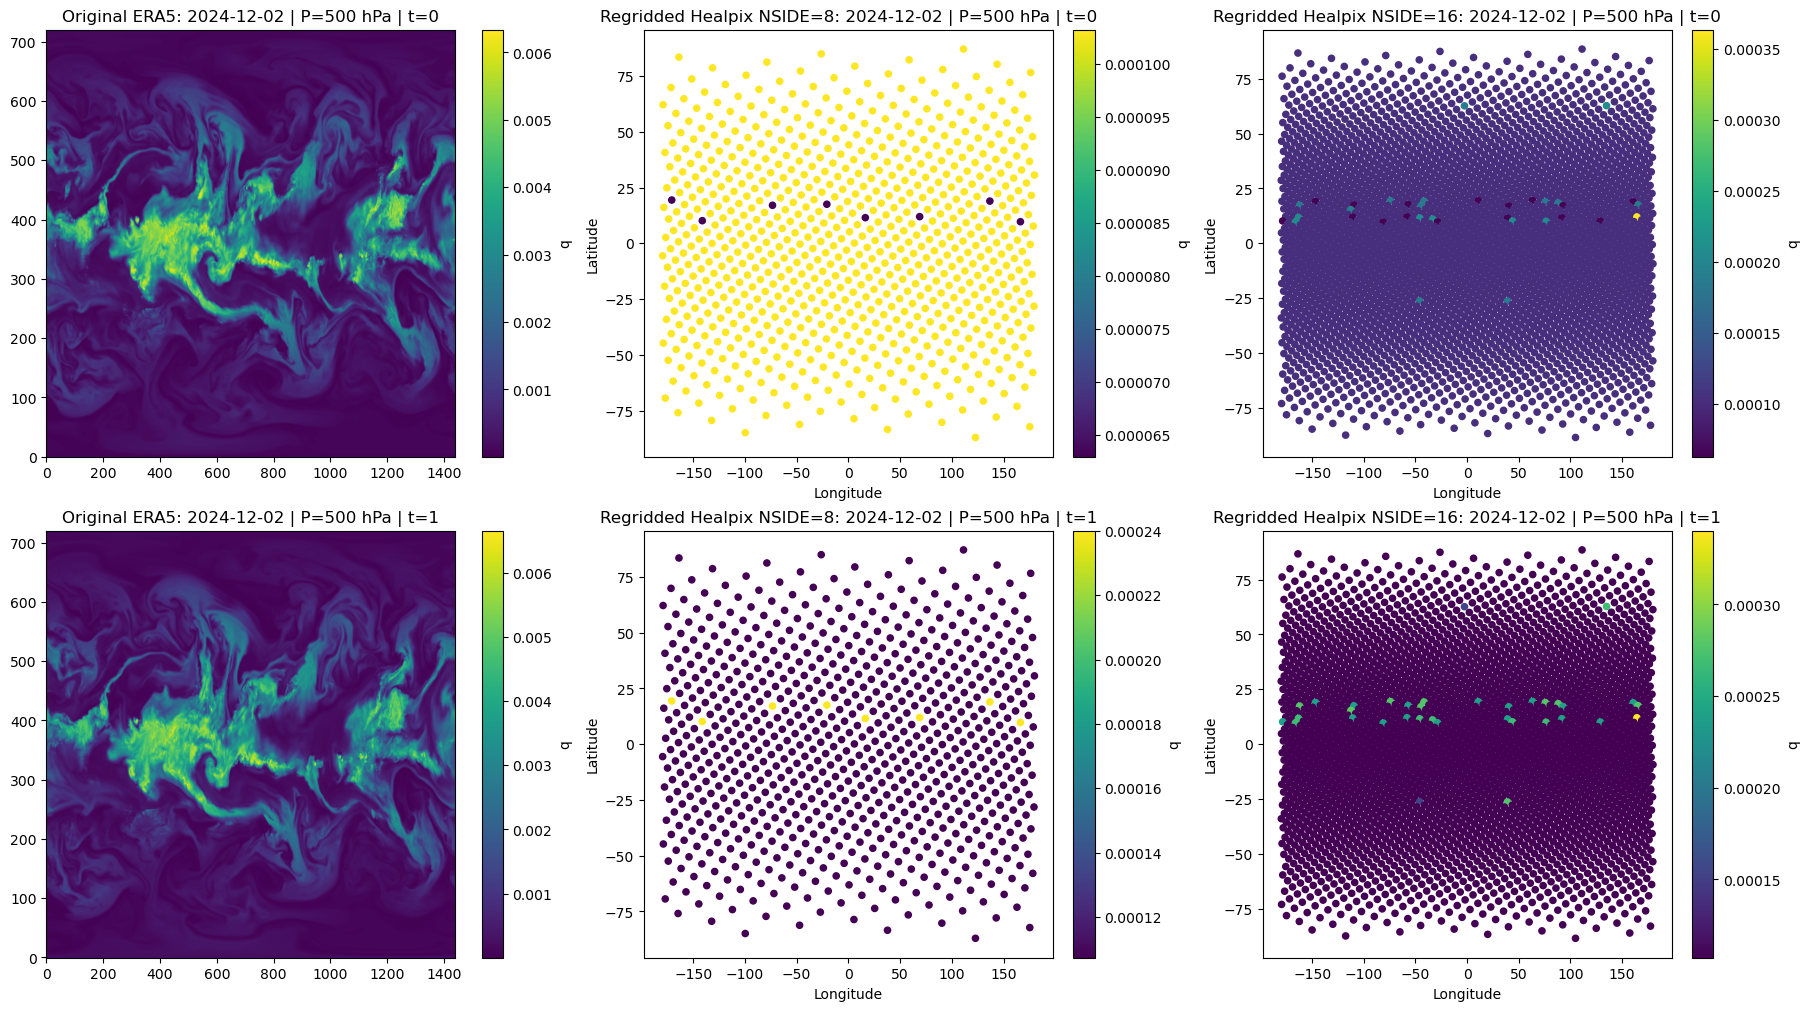

In [97]:
plot_original_and_regridded_final(day=date(2024, 12, 2),
    pressure_level=500,
    time_indices=(0, 1),
    nside_list=(8, 16),
)

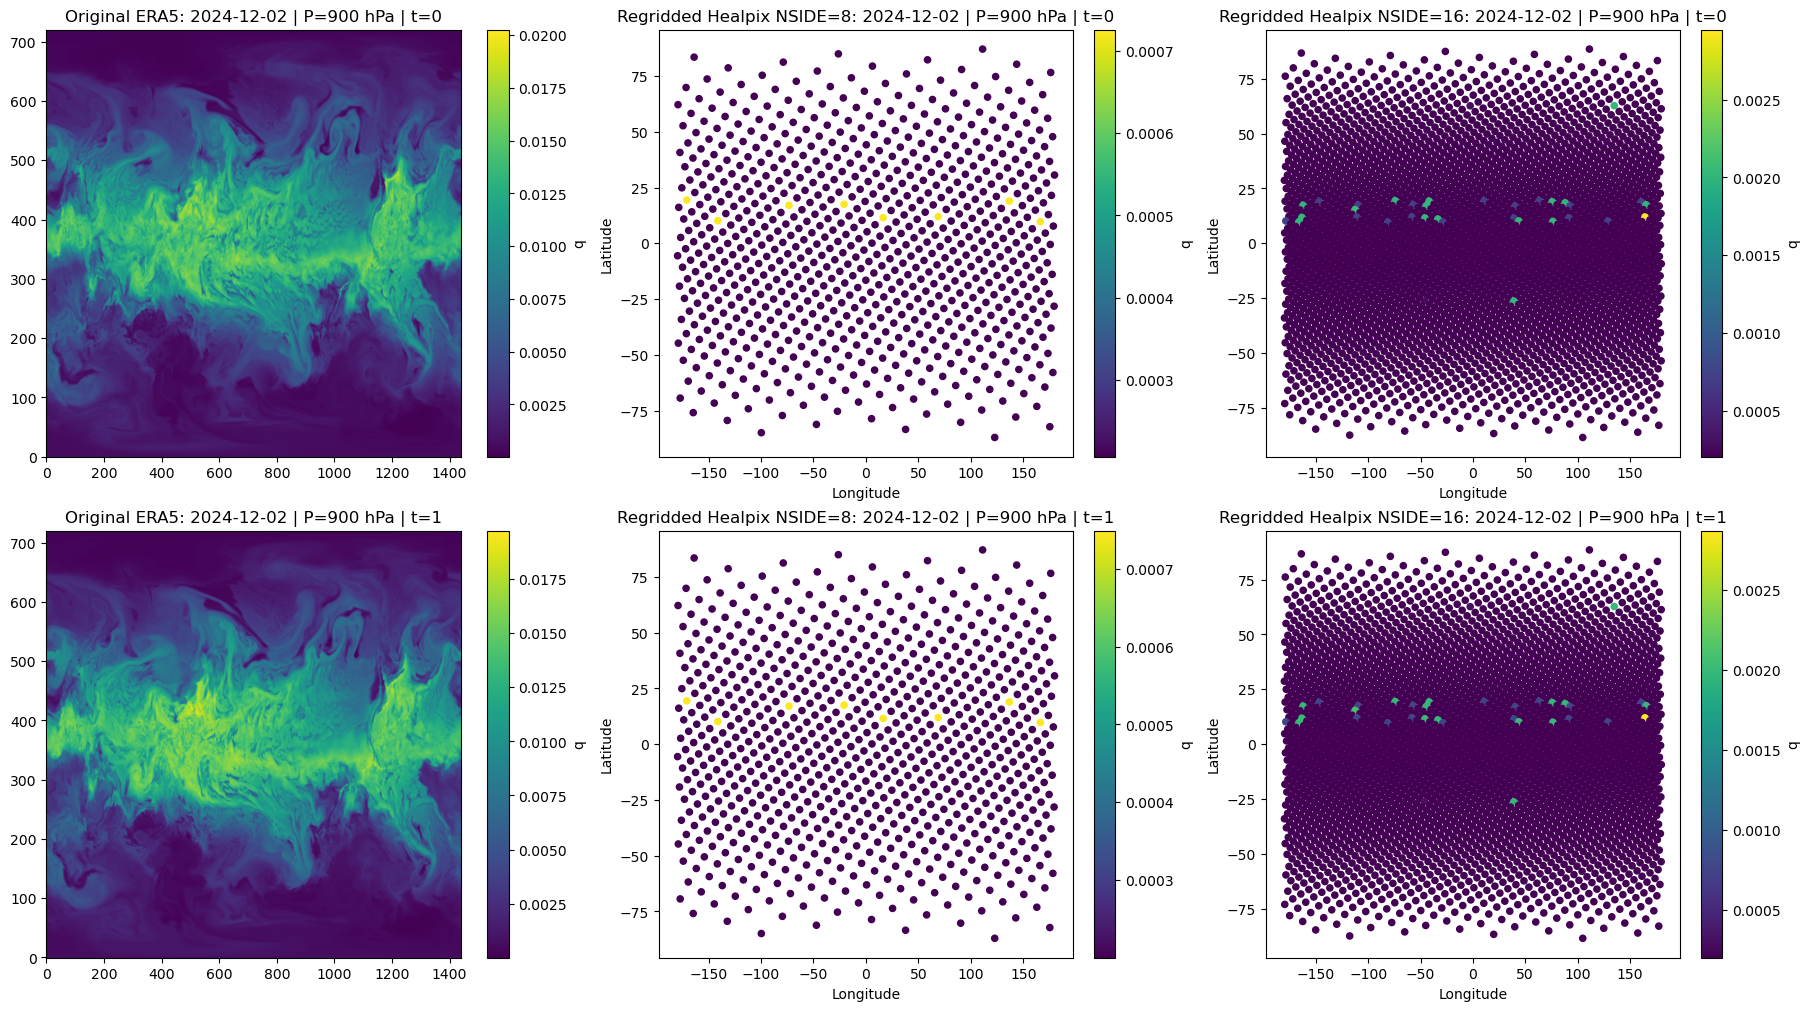

In [102]:
plot_original_and_regridded_final(
    day=date.fromisoformat(PLOT_CONFIG["date"]),
    pressure_level=PLOT_CONFIG["variable"]["pressure_level"],
    time_indices=PLOT_CONFIG["times"]["time_indices"],
    nside_list=PLOT_CONFIG["healpix"]["nsides"],
    zarr_root=Path(PLOT_CONFIG["paths"]["zarr_root"]),
    orig_root=Path(PLOT_CONFIG["paths"]["original_root"]),
)


In [27]:
ds = xr.open_zarr(r"C:\Users\Nils\earth-system-data-processing\data_access\homework02\processed_data_zarr\healpix_n8.zarr")
print(ds)
for var in ds.data_vars:
    print(f"Chunks: {var, ds[var].chunks}")

<xarray.Dataset>
Dimensions:         (pixels: 768, pressure_level: 5, valid_time: 8)
Coordinates:
  * pixels          (pixels) int32 0 1 2 3 4 5 6 ... 761 762 763 764 765 766 767
  * pressure_level  (pressure_level) float64 975.0 900.0 800.0 500.0 300.0
  * valid_time      (valid_time) datetime64[ns] 2024-12-02 ... 2024-12-03T18:...
Data variables:
    q               (valid_time, pressure_level, pixels) float64 dask.array<chunksize=(4, 5, 512), meta=np.ndarray>
Attributes:
    healpix_nside:  8
Chunks: ('q', ((4, 4), (5,), (512, 256)))


In [51]:
import xarray as xr
ds = xr.open_zarr("processed_data_zarr/healpix_n8.zarr")
print(ds)
print(ds.valid_time.values)
print(ds.pixels.values[:10])

<xarray.Dataset>
Dimensions:         (pixels: 768, pressure_level: 5, valid_time: 4)
Coordinates:
  * pixels          (pixels) int32 0 1 2 3 4 5 6 ... 761 762 763 764 765 766 767
  * pressure_level  (pressure_level) float64 975.0 900.0 800.0 500.0 300.0
  * valid_time      (valid_time) datetime64[ns] 2024-12-02 ... 2024-12-02T18:...
Data variables:
    q               (valid_time, pressure_level, pixels) float64 dask.array<chunksize=(4, 5, 512), meta=np.ndarray>
Attributes:
    healpix_nside:  8
['2024-12-02T00:00:00.000000000' '2024-12-02T06:00:00.000000000'
 '2024-12-02T12:00:00.000000000' '2024-12-02T18:00:00.000000000']
[0 1 2 3 4 5 6 7 8 9]
